In [35]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

## a) Построение и тестирование классификатора с использованием модельных данных

In [36]:
dim = 3 # число признаков
n1 = 400 # объем первой выборки
n2 = 500 # объем второй выборки
n = 1000 # объем тестовой выборки

q_training1 = n1 / (n1 + n2) # доля данных в обучающей выборке, взятых из первого распределения
q_training2 = n2 / (n1 + n2) # доля данных в обучающей выборке - из второго распределения
q1 = 0.4 # доля данных в тестовой выборке - из первого распределения
q2 = 1 - q1 # доля данных в тестовой выборке - из второго распределения

# параметры распредеелний
mu1 = np.array([0, 1, -1.5])
mu2 = np.array([1.5, 1.5, -2])
cov_matrix_good = np.array([[1.2, 0.2, 0.5], [0.2, 0.7, 0.3], [0.5, 0.3, 0.9]]) # "хорошо" разделенные данные
cov_matrix_bad = cov_matrix_good * 10 # "плохо" разделенные данные

### Смоделируем обучающие и тестовые выборки

In [37]:
training_sample_good1 = multivariate_normal(mean=mu1, cov=cov_matrix_good).rvs(size=n1, random_state=123)
training_sample_good2 = multivariate_normal(mean=mu2, cov=cov_matrix_good).rvs(size=n2, random_state=123)
training_sample_marks = np.hstack((np.zeros(n1), np.ones(n2)))

test_sample_good = np.concatenate([multivariate_normal(mean=mu1, cov=cov_matrix_good).rvs(size=int(n * q1), random_state=345),
                                   multivariate_normal(mean=mu2, cov=cov_matrix_good).rvs(size=int(n * q2), random_state=345)], axis=0)

In [38]:
training_sample_bad1 = multivariate_normal(mean=mu1, cov=cov_matrix_bad).rvs(size=n1, random_state=123)
training_sample_bad2 = multivariate_normal(mean=mu2, cov=cov_matrix_bad).rvs(size=n2, random_state=123)

# test_sample_bad = np.concatenate([multivariate_normal(mean=mu1, cov=cov_matrix_bad).rvs(size=int(n * q1)), multivariate_normal(mean=mu2, cov=cov_matrix_bad).rvs(size=int(n * q2))], axis=0)
test_sample_bad = np.vstack((multivariate_normal(mean=mu1, cov=cov_matrix_bad).rvs(size=int(n * q1), random_state=345),
                             multivariate_normal(mean=mu2, cov=cov_matrix_bad).rvs(size=int(n * q2), random_state=345)))
test_sample_marks = np.hstack((np.zeros(int(n * q1)), np.ones(int(n * q2))))

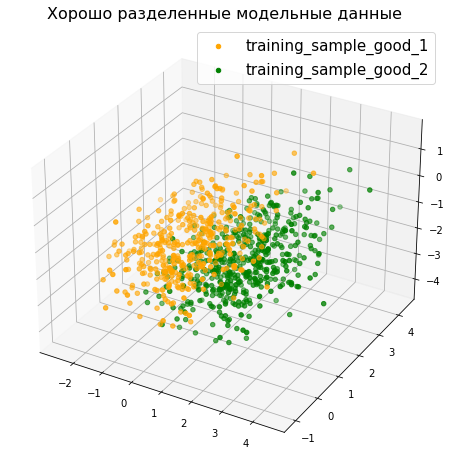

In [39]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=training_sample_good1[:, 0], ys=training_sample_good1[:, 1], zs=training_sample_good1[:, 2], c='orange', label='training_sample_good_1')
ax.scatter(xs=training_sample_good2[:, 0], ys=training_sample_good2[:, 1], zs=training_sample_good2[:, 2], c='g', label='training_sample_good_2')
# ax.scatter(xs=test_sample[:, 0], ys=test_sample[:, 1], zs=test_sample[:, 2], c='b', label='test_sample')

plt.legend(prop={'size': 15})
plt.title("Хорошо разделенные модельные данные", fontsize=16)
plt.show()

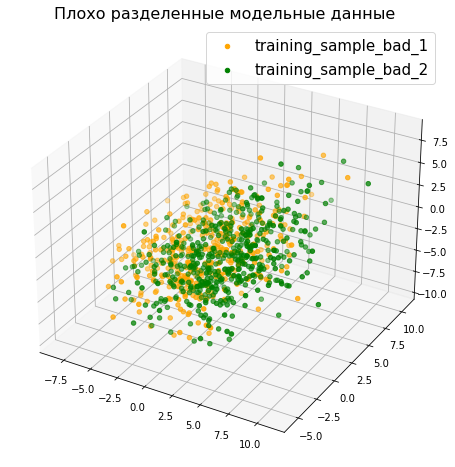

In [40]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=training_sample_bad1[:, 0], ys=training_sample_bad1[:, 1], zs=training_sample_bad1[:, 2], c='orange', label='training_sample_bad_1')
ax.scatter(xs=training_sample_bad2[:, 0], ys=training_sample_bad2[:, 1], zs=training_sample_bad2[:, 2], c='g', label='training_sample_bad_2')
# ax.scatter(xs=test_sample_bad[:, 0], ys=test_sample_bad[:, 1], zs=test_sample_bad[:, 2], c='b', label='test_sample_bad')

plt.legend(prop={'size': 15})
plt.title("Плохо разделенные модельные данные", fontsize=16)
plt.show()

### Вычислим выборочные оценки параметров распределений

In [41]:
def multivariate_mean(sample, size, dim_):
    mu = np.array([])
    for j in range(dim_):
        mu = np.append(mu, np.sum(sample[:, j]) / size)

    return mu

def sample_S(sample, size, mu_est, dim_):
    S = np.zeros(shape=(dim_, dim_))
    for l in range(dim_):
        for j in range(dim_):
            S[l, j] = sum((sample[i, l] - mu_est[l])*(sample[i, j] - mu_est[j]) for i in range(size)) / (size - 1)
            # for i in range(size):
            #     S[l, j] += (sample[i, l] - mu_est[l])*(sample[i, j] - mu_est[j]) / (size - 1)

    return S

def multivariate_cov_matrix(sample1, sample2, size1, size2, multivariate_mu_est, dim_):
    S1 = sample_S(sample1, size1, multivariate_mu_est[0], dim_)
    S2 = sample_S(sample2, size2, multivariate_mu_est[1], dim_)

    S = ((size1 - 1) * S1 + (size2 - 1) * S2) / (size1 + size2 - 2)
    return S

In [42]:
mu1_good_est = multivariate_mean(training_sample_good1, n1, dim)
mu2_good_est = multivariate_mean(training_sample_good2, n2, dim)
mu_good_est = np.array([mu1_good_est, mu2_good_est])
# print(mu_est)
cov_matrix_good_est = multivariate_cov_matrix(training_sample_good1, training_sample_good2, n1, n2, mu_good_est, dim)

print(f"Заданные значения парметров распределений:\n Среднее: {mu1}, {mu2}\n Ковариационная матрица:\n{cov_matrix_good}")
print(f"\nВыборочные оценки парметров распределений:\n Среднее: {mu_good_est[0]}, {mu_good_est[1]}\n Ковариационная матрица:\n{cov_matrix_good_est}")

Заданные значения парметров распределений:
 Среднее: [ 0.   1.  -1.5], [ 1.5  1.5 -2. ]
 Ковариационная матрица:
[[1.2 0.2 0.5]
 [0.2 0.7 0.3]
 [0.5 0.3 0.9]]

Выборочные оценки парметров распределений:
 Среднее: [ 0.03259111  1.04239009 -1.47577711], [ 1.50272217  1.51016601 -1.99153676]
 Ковариационная матрица:
[[1.01133908 0.10557364 0.37990203]
 [0.10557364 0.7285143  0.26631713]
 [0.37990203 0.26631713 0.82720077]]


In [43]:
mu1_bad_est = multivariate_mean(training_sample_bad1, n1, dim)
mu2_bad_est = multivariate_mean(training_sample_bad2, n2, dim)
mu_bad_est = np.array([mu1_bad_est, mu2_bad_est])
# print(mu_est)
cov_matrix_bad_est = multivariate_cov_matrix(training_sample_bad1, training_sample_bad2, n1, n2, mu_bad_est, dim)

print(f"Заданные значения парметров распределений:\n Среднее: {mu1}, {mu2}\n Ковариационная матрица:\n{cov_matrix_bad}")
print(f"\nВыборочные оценки парметров распределений:\n Среднее: {mu_bad_est[0]}, {mu_bad_est[1]}\n Ковариационная матрица:\n{cov_matrix_bad_est}")

Заданные значения парметров распределений:
 Среднее: [ 0.   1.  -1.5], [ 1.5  1.5 -2. ]
 Ковариационная матрица:
[[12.  2.  5.]
 [ 2.  7.  3.]
 [ 5.  3.  9.]]

Выборочные оценки парметров распределений:
 Среднее: [ 0.10306214  1.13404925 -1.42340051], [ 1.50860827  1.53214776 -1.97323688]
 Ковариационная матрица:
[[10.11339075  1.05573639  3.7990203 ]
 [ 1.05573639  7.285143    2.66317129]
 [ 3.7990203   2.66317129  8.27200772]]


### Построим классификатор

In [44]:
def discriminant_fun(alpha, vect):
    z = sum([a * x for a, x in zip(alpha, vect)])
    return z

def create_classifier(training1, training2, size1, size2, q1_, q2_, mu_est, cov_matrix_est):
    a = np.matmul(np.linalg.inv(cov_matrix_est), (mu_est[0] - mu_est[1]))
    mean_z1 = sum([discriminant_fun(a, training1[i, :]) for i in range(size1)]) / size1
    mean_z2 = sum([discriminant_fun(a, training2[i, :]) for i in range(size2)]) / size2
    mean_z = np.array([mean_z1, mean_z2])
    threshold = (mean_z1 + mean_z2) / 2.0 + np.log(q2_ / q1_)

    return a, mean_z, threshold

def classify(vect, alpha, threshold):
    z = discriminant_fun(alpha, vect)
    if z >= threshold:
        return 0
    else:
        return 1

In [45]:
alpha_good, mean_z_good, threshold_good = create_classifier(training_sample_good1, training_sample_good2, n1, n2, q_training1, q_training2, mu_good_est, cov_matrix_good_est)
alpha_bad, mean_z_bad, threshold_bad = create_classifier(training_sample_bad1, training_sample_bad2, n1, n2, q_training1, q_training2, mu_bad_est, cov_matrix_bad_est)

### Оценим вероятности ошибочной классификации полученных классификаторов

In [46]:
def err_prob_est(m1, m2, size1, size2):
    print(f"        P(2|1) = {m1 / size1}")
    print(f"        P(1|2) = {m2 / size2}")

In [47]:
def mahalanobis_biased_est(alpha, mean_z, cov_matrix_est):
    var_z = 0
    for l in range(dim):
        for j in range(dim):
            var_z += alpha[l] * cov_matrix_est[l, j] * alpha[j]

    return (mean_z[0] - mean_z[1]) ** 2 / var_z

def mahalanobis_unbiased_est(alpha, mean_z, cov_matrix_est, size1, size2):
    D = mahalanobis_biased_est(alpha, mean_z, cov_matrix_est)
    D_unbiased = (size1 + size2 - dim - 3) * D / (size1 + size2 - 2) - dim * (1 / size1 +  1 / size2)
    return D_unbiased

def mahalanobis_err_prob_est(alpha, mean_z, cov_matrix_est, q1_, q2_):
    K = np.log(q2_ / q1_)
    mah_biased_est = mahalanobis_biased_est(alpha, mean_z, cov_matrix_est)
    p21 = norm.cdf((K - 0.5 * mah_biased_est) / mah_biased_est ** 0.5)
    p12 = norm.cdf((-K - 0.5 * mah_biased_est) / mah_biased_est ** 0.5)
    print(f"        P(2|1) = {p21}")
    print(f"        P(1|2) = {p12}")

##### Классифицируем обучающие выборки и найдем доли неправильно классифицированных объектов.

In [48]:
# Классифицируем обучающие выборки моделью, построенной по хорошо разделенным данным
training_good_classification_res = np.array([])
training_bad_classification_res = np.array([])

training_sample_good = np.vstack((training_sample_good1, training_sample_good2))
training_sample_bad = np.vstack((training_sample_bad1, training_sample_bad2))

for vect in training_sample_good:
    training_good_classification_res = np.append(training_good_classification_res, classify(vect, alpha_good, threshold_good))
cm_training_good = confusion_matrix(training_sample_marks, training_good_classification_res)
tn_1, fp_1, fn_1, tp_1 = cm_training_good.ravel()
m1_good = fp_1
m2_good = fn_1
# m1_good = len(training_good1_classification_res[training_good1_classification_res == 1]) # ожидаемый класс - 0, получили 1

# for vect in training_sample_good2:
#     training_good2_classification_res = np.append(training_good2_classification_res, classify(vect, alpha_good, mean_z_good, threshold_good))
# cm_training2_good = confusion_matrix(sample_marks, training_good2_classification_res)
# tn_2, fp_2, fn_2, tp_2 = cm_training2_good.ravel()
# # m2_good = len(training_good2_classification_res[training_good2_classification_res == 0]) # ожидаемый класс 1, получили 0

# Классифицируем обучающие выборки моделью, построенной по плохо разделенным данным
# training_bad2_classification_res = np.array([])

for vect in training_sample_bad:
    training_bad_classification_res = np.append(training_bad_classification_res, classify(vect, alpha_bad, threshold_bad))
cm_training_bad = confusion_matrix(training_sample_marks, training_bad_classification_res)
tn_2, fp_2, fn_2, tp_2 = cm_training_bad.ravel()
m1_bad = fp_2
m2_bad = fn_2
# m1_bad = len(training_bad1_classification_res[training_bad1_classification_res == 1]) # ожидаемый класс - 0, получили 1

# for vect in training_sample_bad2:
#     training_bad2_classification_res = np.append(training_bad2_classification_res, classify(vect, alpha_bad, mean_z_bad, threshold_bad))
# cm_training2_bad = confusion_matrix(sample_marks, training_bad2_classification_res)
# tn_2, fp_2, fn_2, tp_2 = cm_training2_bad.ravel()
# # m2_bad = len(training_bad2_classification_res[training_bad2_classification_res == 0]) # ожидаемый класс 1, получили 0

Оценка вероятности ошибочной классификации:
	Классификтор, построенный по хорошо разделенным данным:
        P(2|1) = 0.165
        P(1|2) = 0.136
	Классификтор, построенный по плохо разделенным данным:
        P(2|1) = 0.5125
        P(1|2) = 0.248

Оценка вероятности ошибочной классификации по расстоянию Махаланобиса:
	Классификатор, построенный по хорошо разделенным данным:
        P(2|1) = 0.1697377061775993
        P(1|2) = 0.12188158505946445
	Классификатор, построенный по плохо разделенным данным:
        P(2|1) = 0.5072520214845598
        P(1|2) = 0.2519728011188915


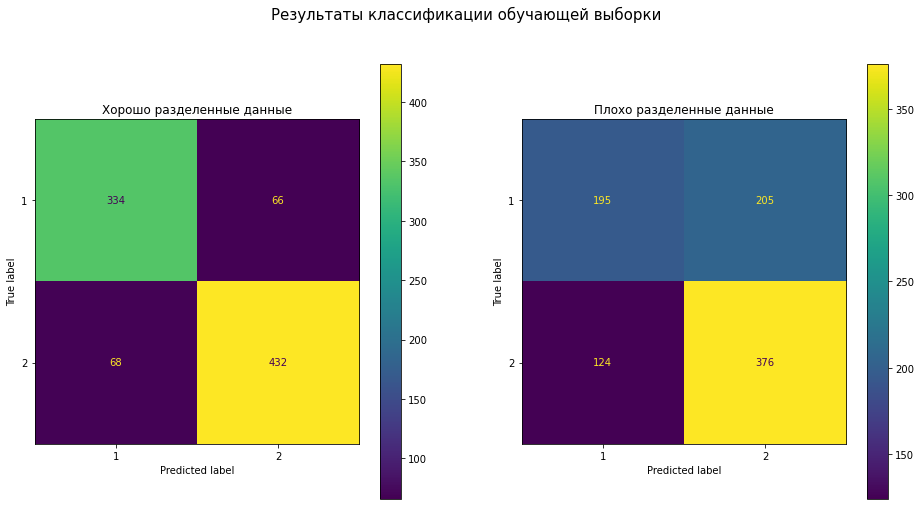

In [49]:
print("Оценка вероятности ошибочной классификации:\n\tКлассификтор, построенный по хорошо разделенным данным:")
err_prob_est(m1_good, m2_good, n1, n2)
print("\tКлассификтор, построенный по плохо разделенным данным:")
err_prob_est(m1_bad, m2_bad, n1, n2)

print("\nОценка вероятности ошибочной классификации по расстоянию Махаланобиса:\n\tКлассификатор, построенный по хорошо разделенным данным:")
mahalanobis_err_prob_est(alpha_good, mean_z_good, cov_matrix_good_est, q_training1, q_training2)
print("\tКлассификатор, построенный по плохо разделенным данным:")
mahalanobis_err_prob_est(alpha_bad, mean_z_bad, cov_matrix_bad_est, q_training1, q_training2)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_training_good, display_labels=["1", "2"]).plot(ax=ax[0])
ConfusionMatrixDisplay(confusion_matrix=cm_training_bad, display_labels=["1", "2"]).plot(ax=ax[1])
fig.suptitle("Результаты классификации обучающей выборки", fontsize=15)
ax[0].set_title("Хорошо разделенные данные")
ax[1].set_title("Плохо разделенные данные")
plt.show()

### Классифицируем тестовые выборки

In [50]:
good_classification_res = np.array([])
for vect in test_sample_good:
    good_classification_res = np.append(good_classification_res, classify(vect, alpha_good, threshold_good))

bad_classification_res = np.array([])
for vect in test_sample_bad:
    bad_classification_res = np.append(bad_classification_res, classify(vect, alpha_bad, threshold_bad))

cm_good = confusion_matrix(test_sample_marks, good_classification_res)
cm_bad = confusion_matrix(test_sample_marks, bad_classification_res)

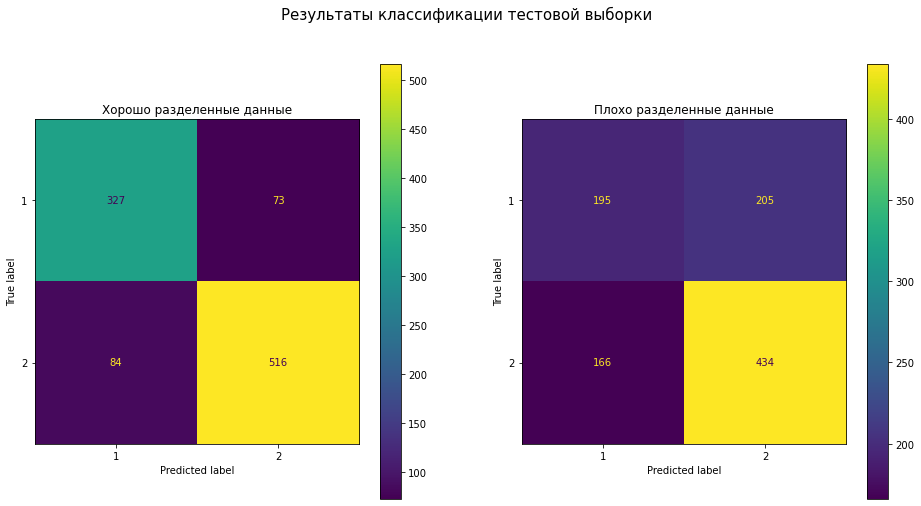

In [51]:
# fig1 = plt.figure(figsize=(16, 8))
# ax = fig1.add_subplot(projection='3d')
# ax.scatter(xs=test_sample_good[:, 0], ys=test_sample_good[:, 1], zs=test_sample_good[:, 2], c=good_classification_res)

# plt.legend(prop={'size': 15})
# plt.title("Результат классификации тестовой выборки с хорошо разделенными данными", fontsize=16)
# plt.show()

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_good, display_labels=["1", "2"]).plot(ax=ax[0])
ConfusionMatrixDisplay(confusion_matrix=cm_bad, display_labels=["1", "2"]).plot(ax=ax[1])
fig.suptitle("Результаты классификации тестовой выборки", fontsize=15)
ax[0].set_title("Хорошо разделенные данные")
ax[1].set_title("Плохо разделенные данные")
plt.show()

In [52]:
tn_1, fp_1, fn_1, tp_1 = cm_good.ravel()
m1_good = fp_1
m2_good = fn_1

tn_2, fp_2, fn_2, tp_2 = cm_bad.ravel()
m1_bad = fp_2
m2_bad = fn_2

print("Эмпирические вероятности ошибочной классификации:\n\tКлассификтор, построенный по хорошо разделенным данным:")
err_prob_est(m1_good, m2_good, n * q1, n  * q2)
print("\tКлассификтор, построенный по плохо разделенным данным:")
err_prob_est(m1_bad, m2_bad, n * q1, n  * q2)

Эмпирические вероятности ошибочной классификации:
	Классификтор, построенный по хорошо разделенным данным:
        P(2|1) = 0.1825
        P(1|2) = 0.14
	Классификтор, построенный по плохо разделенным данным:
        P(2|1) = 0.5125
        P(1|2) = 0.27666666666666667


In [53]:
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(xs=test_sample_bad[:, 0], ys=test_sample_bad[:, 1], zs=test_sample_bad[:, 2], c=bad_classification_res)
#
# # plt.legend(prop={'size': 15})
# plt.title("Результат классификации тестовой выборки с плохо разделенными данными", fontsize=16)
# plt.show()
#
# fig = plt.figure(figsize=(10, 8))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_bad)
# disp.plot()

## b) Построение и тестирование классификатора с использованием данных из репозитория

In [54]:
rep_dim = 24
rep_size = 1000
rep_train_part = 0.2
rep_test_part = 1 - rep_train_part

In [55]:
with open("german.data-numeric") as data:
    rep_objects = np.empty((0, rep_dim + 1))
    rep_marks = np.array([])
    for str in data:
        obj_str = str.split()
#         rep_obj = list(map(float, obj_str[:-1]))
        rep_obj = list(map(float, obj_str))
        rep_objects = np.append(rep_objects, [rep_obj], axis=0)
#         rep_marks = np.append(rep_marks, int(obj_str[-1]))

# Посмотрим на соотношение классов
size_1 = len(rep_objects[rep_objects[:, -1] == 1])
size_2 = len(rep_objects[rep_objects[:, -1] == 2])

print(size_1)
print(size_2)

# Случайным образом разделяем данные на обучающую и тестовую выборку в заданном соотношении
rep_train_sample, rep_test_sample_ = train_test_split(rep_objects, train_size = rep_train_part, random_state = 12666)

# Разделяем обучающие выборки по классам
rep_train_sample1 = np.array(rep_train_sample[rep_train_sample[:, -1] == 1, :-1])
rep_train_sample2 = np.array(rep_train_sample[rep_train_sample[:, -1] == 2, :-1])
rep_train_sample_marks = np.hstack((np.ones(rep_train_sample1.shape[0]), np.full(rep_train_sample2.shape[0], 2)))

rep_n1 = rep_train_sample1.shape[0]
rep_n2 = rep_train_sample2.shape[0]
print(rep_train_sample1.shape)
print(rep_train_sample2.shape)

rep_q_training1 = rep_n1 / (rep_n1 + rep_n2)
rep_q_training2 = rep_n2 / (rep_n1 + rep_n2)

print(rep_q_training1)
print(rep_q_training2)

# Выносим в отдельный вектор метки для проверки, убираем лишний столбец из признаков
rep_test_sample_marks = rep_test_sample_[:, -1]
rep_test_sample = rep_test_sample_[:, :-1]

700
300
(128, 24)
(72, 24)
0.64
0.36


### Строим классификатор по данным из репозиторя

In [56]:
mu1_rep_est = multivariate_mean(rep_train_sample1, rep_n1, rep_dim)
mu2_rep_est = multivariate_mean(rep_train_sample2, rep_n2, rep_dim)
mu_rep_est = np.array([mu1_rep_est, mu2_rep_est])
cov_matrix_rep_est = multivariate_cov_matrix(rep_train_sample1, rep_train_sample2, rep_n1, rep_n2, mu_rep_est, rep_dim)

alpha_rep, mean_z_rep, threshold_rep = create_classifier(rep_train_sample1, rep_train_sample2, rep_n1, rep_n2, rep_q_training1, rep_q_training2, mu_rep_est, cov_matrix_rep_est)

### Оценим вероятности ошибочной классификации полученного классификатора

##### Классифицируем обучающие выборки и найдем доли неправильно классифицированных объектов.

In [57]:
training_rep_classification_res = np.array([])

training_sample_rep = np.vstack((rep_train_sample1, rep_train_sample2))

for vect in training_sample_rep:
    training_rep_classification_res = np.append(training_rep_classification_res, classify(vect, alpha_rep, threshold_rep))
    
training_rep_classification_res = training_rep_classification_res + 1
cm_training_rep = confusion_matrix(rep_train_sample_marks, training_rep_classification_res)
tn_1, fp_1, fn_1, tp_1 = cm_training_rep.ravel()
m1_rep = fp_1
m2_rep = fn_1

Оценка вероятности ошибочной классификации:
        P(2|1) = 0.1484375
        P(1|2) = 0.4583333333333333

Оценка вероятности ошибочной классификации по расстоянию Махаланобиса:
        P(2|1) = 0.11036781665916667
        P(1|2) = 0.27738126454252465


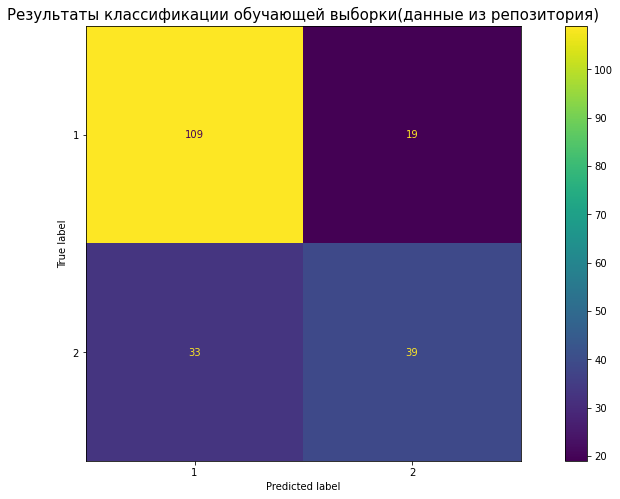

In [58]:
print("Оценка вероятности ошибочной классификации:")
err_prob_est(m1_rep, m2_rep, rep_n1, rep_n2)

print("\nОценка вероятности ошибочной классификации по расстоянию Махаланобиса:")
mahalanobis_err_prob_est(alpha_rep, mean_z_rep, cov_matrix_rep_est, rep_q_training1, rep_q_training2)

fig, ax = plt.subplots(figsize=(16, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_training_rep, display_labels=["1", "2"]).plot(ax=ax)
plt.title("Результаты классификации обучающей выборки(данные из репозитория)", fontsize=15)
# ax.set_title("Хорошо разделенные данные")
plt.show()

### Классифицируем тестовую выборку

In [59]:
rep_classification_res = np.array([])
for vect in rep_test_sample:
    rep_classification_res = np.append(rep_classification_res, classify(vect, alpha_rep, threshold_rep))
    
rep_classification_res = rep_classification_res + 1
cm_rep = confusion_matrix(rep_test_sample_marks, rep_classification_res)

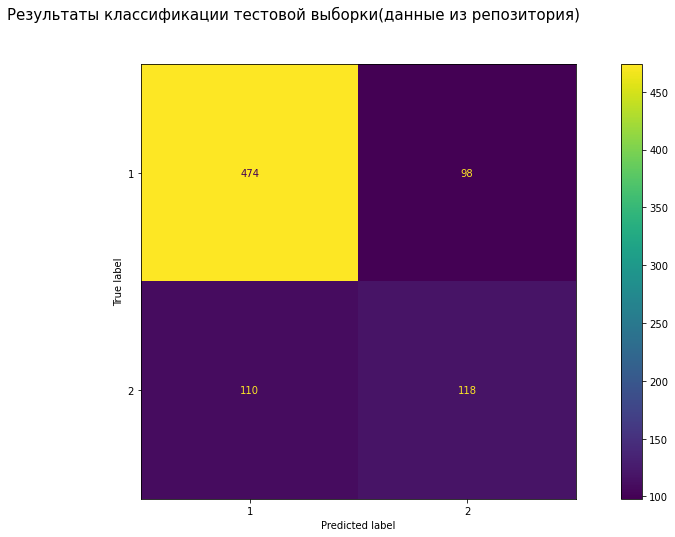

In [60]:
fig, ax = plt.subplots(figsize=(16, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_rep, display_labels=["1", "2"]).plot(ax=ax)
fig.suptitle("Результаты классификации тестовой выборки(данные из репозитория)", fontsize=15)
plt.show()

In [61]:
tn_1, fp_1, fn_1, tp_1 = cm_rep.ravel()
m1_rep = fp_1
m2_rep = fn_1

print("Эмпирические вероятности ошибочной классификации:")
err_prob_est(m1_rep, m2_rep, size_1 - rep_n1, size_2 - rep_n2)

Эмпирические вероятности ошибочной классификации:
        P(2|1) = 0.17132867132867133
        P(1|2) = 0.4824561403508772


## a) Применим метод главных компонент

### К данным из репозитория

In [62]:
def pca_reduce(sample, size, dim_, target_dim):
    if target_dim == 24:
        return sample
    mean = multivariate_mean(sample, size, dim_)
#     print(mean.size)
    cov_matrix = sample_S(sample, size, mean, dim_)
    sample_centered = sample - mean
    eigen_val, eigen_vect = np.linalg.eig(cov_matrix)
#     eigen_val, eigen_vect = zip(*sorted(list(zip(eigen_val, eigen_vect.T)), key=lambda pair: pair[0], reverse=True))
    eigen = sorted(list(zip(eigen_val, eigen_vect.T)), key=lambda pair: pair[0], reverse=True)
#     eigen_val, eigen_vect = np.array(eigen_val), np.array(eigen_vect)
#     eigen_vals = eigen_val[:target_dim]
    eigen_vals = np.array([eigen[i][0] for i in range(target_dim)])

    print(f"Отобрали следующие {target_dim} собcтвенных чисел: {eigen_vals}")
    L = np.vstack(list([eigen[i][1] for i in range(target_dim)]))
#     print(L.shape)
#     print(np.reshape(mean, (mean.size, 1)).shape)
    sample_pca = np.matmul(sample_centered, L.T) + np.matmul(mean, L.T)

#     sample_pca = np.matmul(L, sample_centered.T) + np.matmul(L, np.reshape(mean, (mean.size, 1))) # по лекции еще Т
    
#     sample_pca = sample_pca.T
    return sample_pca

In [63]:
# # Первая обучающая выборка
# # rep_features, rep_marks = rep_objects[:, :-1], rep_objects[:, -1]
# mean_train_1 = multivariate_mean(rep_train_sample1, rep_n1, rep_dim)
# cov_matrix_train_1 = sample_S(rep_train_sample1, rep_n1, mean_train_1, rep_dim)
# rep_train_sample1_centered = rep_train_sample1 - mean_train_1
# eigen_val_train_1, eigen_vect_train_1 = np.linalg.eig(cov_matrix_train_1)
# # print(eigen_vect_train_1)
# # print(eigen_vect_train_1.T)
# # print(eigen_vect_train_1)
# # eigen_val_train_1_, eigen_vect_train_1_ = zip(*sorted(list(zip(eigen_val_train_1, eigen_vect_train_1.T)), key=lambda pair: pair[0], reverse=True))
# eigen_val_train_1_, eigen_vect_train_1_ = zip(*sorted(list(zip(eigen_val_train_1, eigen_vect_train_1.T)), reverse=True))
# print(eigen_val_train_1_)
# eigen_val_train_1_, eigen_vect_train_1_ = np.array(eigen_val_train_1_), np.array(eigen_vect_train_1_)
# vals_train_1 = eigen_val_train_1_[eigen_val_train_1_ > 1]
# print(f"Отобрали следующие {len(vals_train_1)} собcтвенных чисел: {vals_train_1}")

# # eiges = sorted(list(zip(eigen_val_train_1, eigen_vect_train_1.T)), key=lambda x: x[0], reverse=True)
# print()
# print(eigen_vect_train_1_.shape)
# # print(eigen_vect_train_1_.shape)
# # print(eigen_vect_train_1_.T.shape)

# # print(eiges[0][1].shape)

# transform_train_1 = np.vstack(list([eigen_vect_train_1_[i] for i in range(len(vals_train_1))]))
# print(transform_train_1.shape)
# print()
# rep_train_1_pca = np.matmul(rep_train_sample1_centered, transform_train_1.T)
# rep_train_1_pca_ = np.matmul(transform_train_1, rep_train_sample1_centered.T).T # по лекции
# print(rep_train_1_pca.shape, rep_train_1_pca_.shape)
# # print(f"{rep_train_1_pca[-8:, :] - rep_train_1_pca_[-8:, :]}")

# # print(rep_train_1_pca == rep_train_1_pca_)

# # # Вторая обучающая выборка
# # # rep_features, rep_marks = rep_objects[:, :-1], rep_objects[:, -1]
# # mean_train_2 = multivariate_mean(rep_train_sample2, rep_n2, rep_dim)
# # cov_matrix_train_2 = sample_S(rep_train_sample2, rep_n2, mean_train_2, rep_dim)
# # rep_train_sample2_centered = rep_train_sample2 - mean_train_2
# # eigen_val_train_2, eigen_vect_train_2 = np.linalg.eig(cov_matrix_train_2)
# # print(eigen_val_train_2[0])
# # print(eigen_vect_train_2[0])
# # # eigen_val_train_2_, eigen_vect_train_2_ = zip(*sorted(list(zip(eigen_val_train_2, eigen_vect_train_2.T)), key=lambda pair: pair[0], reverse=True))
# # eigen_val_train_2_, eigen_vect_train_2_ = zip(*sorted(list(zip(eigen_val_train_2, eigen_vect_train_2.T)), reverse=True))

# # vals_train_2 = eigen_val_train_2[eigen_val_train_2 > 1]
# # print(f"Отобрали следующие {len(vals_train_2)} собcтвенных чисел: {vals_train_2}")

# # eiges = sorted(list(zip(eigen_val_train_2, eigen_vect_train_2.T)), key=lambda x: x[0], reverse=True)
# # print(eigen_val_train_2_[0])
# # print(eigen_vect_train_2_[0])
# # # print(eiges[0][1].shape)

In [64]:
target_dim = 10
rep_train1_pca = pca_reduce(rep_train_sample1, rep_n1, rep_dim, target_dim)
rep_train2_pca = pca_reduce(rep_train_sample2, rep_n2, rep_dim, target_dim)
print(rep_train1_pca.shape, rep_train2_pca.shape)
# print(rep_train1_pca == rep_train_sample1)
# rep_pca_dim = rep_train1_pca.shape[1]
# print(rep_pca_dim)
# print(rep_train_1_pca == rep_train1_pca)
# print(rep_train_1_pca_ == rep_train1_pca)

Отобрали следующие 10 собcтвенных чисел: [7.73528655e+02 1.39146788e+02 7.10133059e+01 2.62376280e+00
 1.65879076e+00 1.59925871e+00 1.22769903e+00 9.59485212e-01
 7.42429182e-01 5.04202346e-01]
Отобрали следующие 10 собcтвенных чисел: [1.21630963e+03 1.24154618e+02 1.01624113e+02 2.80751443e+00
 2.11508562e+00 1.24133405e+00 1.04192008e+00 8.00018187e-01
 6.86305192e-01 4.95222196e-01]
(128, 10) (72, 10)


In [65]:
from sklearn.decomposition import PCA
pca = PCA(n_components = target_dim)
rep_train1_pca = pca.fit_transform(rep_train_sample1)
rep_train2_pca = pca.fit_transform(rep_train_sample2)
print(rep_train1_pca.shape, rep_train2_pca.shape)
# print(XPCAreduced.shape)
# print(XPCAreduced == rep_train_sample1)


(128, 10) (72, 10)


### Строим классификатор по обучающим выборкам меньшей размерности

In [66]:
mu1_rep_pca_est = multivariate_mean(rep_train1_pca, rep_n1, target_dim)
mu2_rep_pca_est = multivariate_mean(rep_train2_pca, rep_n2, target_dim)
mu_rep_pca_est = np.array([mu1_rep_pca_est, mu2_rep_pca_est])
cov_matrix_rep_pca_est = multivariate_cov_matrix(rep_train1_pca, rep_train2_pca, rep_n1, rep_n2, mu_rep_pca_est, target_dim)

alpha_pca_rep, mean_z_pca_rep, threshold_pca_rep = create_classifier(rep_train1_pca, rep_train2_pca, rep_n1, rep_n2, rep_q_training1, rep_q_training2, mu_rep_pca_est, cov_matrix_rep_pca_est)

### Оценим вероятности ошибочной классификации полученного классификатора

##### Классифицируем обучающие выборки и найдем доли неправильно классифицированных объектов.

In [67]:
training_rep_pca_classification_res = np.array([])

training_sample_pca_rep = np.vstack((rep_train1_pca, rep_train2_pca))

for vect in training_sample_pca_rep:
    training_rep_pca_classification_res = np.append(training_rep_pca_classification_res, classify(vect, alpha_pca_rep, threshold_pca_rep))
    
training_rep_pca_classification_res = training_rep_pca_classification_res + 1
print(len(training_rep_pca_classification_res))
cm_training_pca_rep = confusion_matrix(rep_train_sample_marks, training_rep_pca_classification_res)
print(cm_training_pca_rep)
tn_1, fp_1, fn_1, tp_1 = cm_training_pca_rep.ravel()
m1_pca_rep = fp_1
m2_pca_rep = fn_1

200
[[128   0]
 [ 72   0]]


Оценка вероятности ошибочной классификации:
        P(2|1) = 0.0
        P(1|2) = 1.0

Оценка вероятности ошибочной классификации по расстоянию Махаланобиса:
        P(2|1) = 0.0
        P(1|2) = 1.0


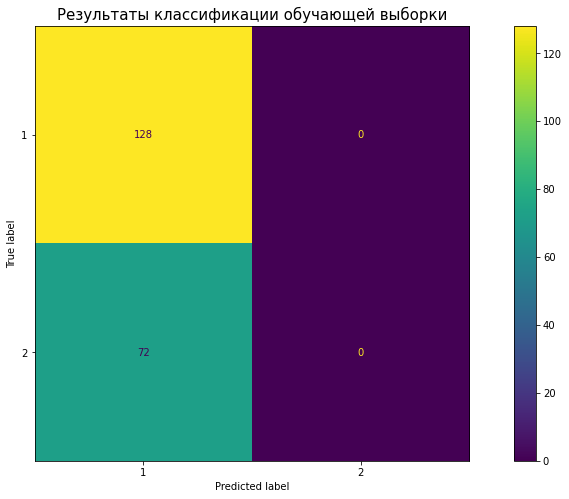

In [68]:
print("Оценка вероятности ошибочной классификации:")
err_prob_est(m1_pca_rep, m2_pca_rep, rep_n1, rep_n2)

print("\nОценка вероятности ошибочной классификации по расстоянию Махаланобиса:")
mahalanobis_err_prob_est(alpha_pca_rep, mean_z_pca_rep, cov_matrix_rep_pca_est, rep_q_training1, rep_q_training2)

fig, ax = plt.subplots(figsize=(16, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_training_pca_rep, display_labels=["1", "2"]).plot(ax=ax)
plt.title("Результаты классификации обучающей выборки", fontsize=15)
plt.show()